## Topic Trends final code - Coronavirus

This code was created from Martha and Sean's emerging topic code and was used to create the hottest/coldest topics static graphics for the full, pandemics, and coronavirus corpora.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time
import re

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm
from scipy import stats

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

import seaborn as sns

### Data Ingestion

In [2]:
# full corpus
#df = pd.read_pickle("../../data/final/final_dataset_7-20.pkl")

# pandemic corpus
#df = pd.read_pickle("../../../../data/prd/Tech-Report/case_studies/coronavirus_corpus.pkl")
df = pd.read_pickle("./term-match-corpus.pkl")
df.reset_index(inplace=True)

# coronavirus corpus -- NEED TO CREATE
#df = pd.read_pickle("/home/kjl5t/dspg20RnD/data/final/dashboard_data/corona_corpus.pkl")
#df.reset_index(inplace=True)

In [3]:
df.head()

,level_0,index,original index,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,final_tokens
0,13938,13938,15726,152221,AbstractThe American Society for Virology (ASV...,2008,abstracting; Acquired Immunodeficiency Syndrom...,"INTERNATIONAL CONGRESS OF VIROLOGY, ISTANBUL, ...",HHS,NIH,NIAID,1R13AI075719-01,2/1/2008,1/31/2009,"SAWICKI, DOROTHEA L",NaN,09,807418939,UNIVERSITY OF TOLEDO HEALTH SCI CAMPUS,TOLEDO,OH,436142595,UNITED STATES,2/1/2008,1/31/2009,93.855,2008,30000.0,NaN,1,1,"[american, society, virology_asv, wish, provid..."
1,14418,14418,17118,153617,DESCRIPTION (provided by applicant): Severe a...,2008,Abbreviations; Address; Alleles; Alphavirus; A...,SARS REVERSE GENETICS,HHS,NIH,NIAID,5R01AI059136-05,2/15/2004,1/31/2010,"BARIC, RALPH S",NaN,04,608195277,UNIVERSITY OF NORTH CAROLINA CHAPEL HILL,CHAPEL HILL,NC,275990001,UNITED STATES,2/1/2008,1/31/2010,93.855,2008,271608.0,NaN,1,1,"[severe, acute, respiratory, syndrome, life_th..."
2,14514,14514,17384,153888,DESCRIPTION (provided by applicant): Human cor...,2008,Acute; Age-Years; Antigens; Archives; base; Bi...,EPIDEMIOLOGY AND CLINICAL FEATURES OF HUMAN CO...,HHS,NIH,NIAID,5R03AI068069-02,2/1/2007,1/31/2010,"WILLIAMS, JOHN V",NaN,05,965717143,VANDERBILT UNIVERSITY,NASHVILLE,TN,372407749,UNITED STATES,2/1/2008,1/31/2010,93.855,2008,75292.0,NaN,1,1,"[human, coronaviruse_hcov, initially, identify..."
3,15809,15809,21525,158094,DESCRIPTION (provided by applicant): In Novemb...,2008,Address; Adjuvant; Animals; Antibodies; Antibo...,RECOMBINANT & LIVE ORAL SALMONELLA TYPHI HYBRI...,HHS,NIH,NIAID,5R01AI029471-17,4/1/1990,2/28/2010,"LEVINE, MYRON MAX",NaN,07,188435911,UNIVERSITY OF MARYLAND BALTIMORE,BALTIMORE,MD,212011508,UNITED STATES,3/1/2008,2/28/2010,93.855,2008,619162.0,NaN,1,1,"[november, 2002, china, outbreak, atypical, pn..."
4,16846,16846,25699,162605,DESCRIPTION (provided by applicant): The SARS ...,2008,Aspirate substance; base; Binding; biodefense;...,DIFFERENTIATION OF COMMON RESPIRATORY VIRUSES ...,HHS,NIH,NIAID,5U01AI061611-04,4/15/2005,3/31/2010,"PORITZ, MARK AARON",NaN,04,556915205,IDAHO TECHNOLOGY,SALT LAKE CITY,UT,841072649,UNITED STATES,4/1/2008,3/31/2010,93.855,2008,715172.0,NaN,1,1,"[sars, outbreak, demonstrate, lethality, commu..."


In [4]:
# input needed for LDA, NMF (all from Scikit-Learn) is one string per document (not a list of strings)

text = []
docs = df["final_tokens"]

for abstract in docs:
    text.append(" ".join(abstract))

### Functions needed for all models

In [5]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(topic_term_mat, vectorizer, top_n=10):
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [6]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def str_topics(topic_term_mat, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

### NMF

- Pandemic Model: pandemic dataset, 30, random_state = 1
- Coronavirus Model: coronavirus dataset, 25, random_state = 1

In [7]:
# use for full dataset
#tfidf_vectorizer = TfidfVectorizer(max_df=0.6, min_df=20, lowercase=False, max_features=int(len(docs)/2))
#tf_idf = tfidf_vectorizer.fit_transform(text)

stop_wds = ['research', 'study', 'project']

# use for pandemic or coronavirus dataset
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=False, stop_words=stop_wds)
tf_idf = tfidf_vectorizer.fit_transform(text)


In [8]:
# create model

num_topics = 25 

t1 = time.time()
nmf_model = NMF(n_components=num_topics, random_state = 1)
doc_topic = nmf_model.fit_transform(tf_idf)
t2 = time.time()
print(f"  Model time: {t2-t1}")

topic_term = nmf_model.components_

  Model time: 2.0944714546203613


/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2020.11-py3.8/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [9]:
print_topics(topic_term, tfidf_vectorizer, 10)


Topic 0:
('rna', 1.4643558897015518)
('protein', 1.1814201811880138)
('replication', 0.8500011524299512)
('coronavirus', 0.7820987316922209)
('viral', 0.7068812157307575)
('coronaviruse', 0.5634737824116637)
('structure', 0.5623802778729274)
('interaction', 0.5400634430941891)
('virus', 0.5321837497299449)
('genome', 0.5159597664004993)

Topic 1:
('immune', 0.8538781407110131)
('polygenic', 0.5890003829898189)
('trait', 0.47591511819186694)
('regulate', 0.44325961279094817)
('protective', 0.3560777367497647)
('response', 0.352254570119274)
('immunity', 0.34852738238210085)
('kinetic', 0.31181727087402694)
('phenotype', 0.3055942283737491)
('diverse', 0.27652132599295176)

Topic 2:
('disease', 0.5550989954904842)
('lung', 0.5003308879716587)
('develop', 0.3815401000109196)
('prognostic_indicator', 0.3620980696250359)
('severity', 0.3295844610947683)
('model', 0.3251323044660862)
('respiratory', 0.32141537853690877)
('etiology', 0.31628348318099614)
('human', 0.30956175422733945)
('use'

### Topic Trends

In [10]:
# Extract Year from PROJECT_START_DATE

#On our graphs, we want to be able to show year. Therefore, this getYear function gets the year from different date formats from Project Start Year/End Year

#START

def getYear(a):   
    a = str(a)
    if a.find("/"):
        splitdate = a.split("/")
        if len(splitdate) == 3:
            a = splitdate[2]
        else:
            a = splitdate[0]
    year = str(a)
    return year

df['START_YEAR'] = df['PROJECT_START_DATE'].apply(getYear)

In [11]:
sum(df['PROJECT_START_DATE'].isna())

0

In [12]:
df['START_YEAR'].value_counts(dropna=False)

2008    56
2009    50
2011    45
2010    42
2013    41
2014    39
2015    39
2016    36
2012    32
2018    32
2017    25
2005    16
2019    15
2007    14
2004    13
2006     9
1991     6
2001     6
1985     5
2002     4
1998     3
1975     2
1999     2
1980     2
1988     2
2003     1
1990     1
1979     1
2000     1
1977     1
Name: START_YEAR, dtype: int64

In [13]:
#Pulls sample data subsetted by year then takes mean theta for each abstract

topic_frame = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_frame["START_YEAR"] = df["START_YEAR"]


#### compute count of projects with weight > 0 for each topic

In [14]:
topic_proj_count = topic_frame.copy()

In [15]:
topic_proj_count.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,START_YEAR
0,0.007705,0.000000,0.000000,0.012277,0.000000,0.108320,0.000000,0.011560,0.001852,0.034357,0.000000,0.013506,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002823,0.001770,0.001025,0.000000,0.006821,0.000000,0.000000,2008
1,0.038808,0.000000,0.012548,0.109695,0.010771,0.013055,0.009782,0.005031,0.000000,0.020289,0.000000,0.024532,0.000000,0.017104,0.026232,0.007749,0.014243,0.000000,0.034413,0.000417,0.003597,0.000000,0.042327,0.000000,0.000000,2004
2,0.012024,0.000000,0.078429,0.016172,0.000503,0.013341,0.000000,0.000000,0.000000,0.000148,0.002994,0.003511,0.001048,0.000000,0.022793,0.000000,0.004257,0.000000,0.082788,0.000000,0.000000,0.000000,0.000000,0.018065,0.029465,2007
3,0.005312,0.017959,0.035318,0.126165,0.029741,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021500,0.000000,0.000000,0.019115,0.009577,0.000000,0.044107,0.000000,0.000000,0.005479,0.107050,0.000000,0.005809,1990
4,0.014607,0.000000,0.072120,0.009883,0.002707,0.006780,0.007198,0.002784,0.000000,0.000000,0.000000,0.009442,0.000000,0.011067,0.010333,0.001700,0.002935,0.006329,0.020522,0.011571,0.000000,0.000000,0.009417,0.000310,0.000000,2005


In [16]:
topic_count_bool = (topic_proj_count.iloc[:,0:num_topics] > 0)
topic_count_bool["START_YEAR"] = topic_proj_count["START_YEAR"]

In [17]:
topic_count_bool

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,START_YEAR
0,True,False,False,True,False,True,False,True,True,True,False,True,False,False,False,False,False,False,True,True,True,False,True,False,False,2008
1,True,False,True,True,True,True,True,True,False,True,False,True,False,True,True,True,True,False,True,True,True,False,True,False,False,2004
2,True,False,True,True,True,True,False,False,False,True,True,True,True,False,True,False,True,False,True,False,False,False,False,True,True,2007
3,True,True,True,True,True,False,False,False,False,False,False,False,True,False,False,True,True,False,True,False,False,True,True,False,True,1990
4,True,False,True,True,True,True,True,True,False,False,False,True,False,True,True,True,True,True,True,True,False,False,True,True,False,2005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,True,True,True,True,True,True,False,False,False,False,True,False,False,True,True,False,True,False,True,False,True,True,True,False,True,2016
537,False,False,False,False,False,False,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,True,False,2018
538,True,True,True,True,False,True,False,False,True,True,False,True,False,False,True,True,True,True,True,False,False,False,False,False,False,2011
539,False,False,True,True,True,False,False,False,True,True,True,False,False,False,False,False,False,True,False,False,False,False,True,False,True,2019


In [18]:
topic_count_bool.sum(axis=1).median()

10.0

In [19]:
# same calculation but grouped by year

topic_counts = topic_count_bool.groupby("START_YEAR").sum().reset_index()
topic_counts = topic_counts.sort_values(by = "START_YEAR")  # pretty sure this is unnecessary
topic_counts["START_YEAR"] = topic_counts["START_YEAR"].astype(int)


In [20]:
#topic_counts

In [21]:
topic_counts_filt = topic_counts[topic_counts["START_YEAR"] > 2009] 
topic_counts_filt = topic_counts_filt[topic_counts_filt["START_YEAR"] < 2020]

In [22]:
topic_counts_filt

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24
20,2010,23,13,20,16,16,16,20,8,19,11,15,17,24,14,17,13,23,12,23,16,14,18,19,11,21
21,2011,26,13,20,16,13,14,19,15,14,21,4,11,18,10,20,21,12,22,24,10,13,20,15,13,5
22,2012,7,11,14,14,6,5,10,12,11,15,7,8,10,11,7,6,11,17,12,12,11,14,12,12,11
23,2013,19,21,18,15,12,9,6,14,19,16,7,18,10,20,10,18,14,16,16,16,10,13,12,9,9
24,2014,15,16,18,14,12,18,9,11,17,13,18,13,13,11,13,13,12,8,15,14,7,10,7,13,13
25,2015,14,15,19,13,12,13,12,8,13,17,17,13,10,10,10,16,14,16,12,11,9,8,8,11,15
26,2016,13,18,15,11,16,12,5,9,14,8,17,11,9,14,9,9,13,12,13,13,12,10,9,9,12
27,2017,13,13,11,10,7,8,7,7,9,11,16,12,13,10,7,10,10,15,9,10,8,7,12,12,14
28,2018,15,14,11,7,9,9,12,14,14,15,22,11,9,14,4,11,14,12,13,9,10,15,16,15,12
29,2019,4,5,6,3,5,3,7,8,7,6,14,5,6,6,2,6,5,7,5,5,5,7,7,5,5


In [23]:
n_by_topic = topic_counts_filt.sum()[1:]

n_by_topic

Topic 0     149
Topic 1     139
Topic 2     152
Topic 3     119
Topic 4     108
Topic 5     107
Topic 6     107
Topic 7     106
Topic 8     137
Topic 9     133
Topic 10    137
Topic 11    119
Topic 12    122
Topic 13    120
Topic 14     99
Topic 15    123
Topic 16    128
Topic 17    137
Topic 18    142
Topic 19    116
Topic 20     99
Topic 21    122
Topic 22    117
Topic 23    110
Topic 24    117
dtype: int64

In [24]:
n_by_topic[0]

149

#### compute dollars by topic by year

#### calculate mean topic weight by year and standard errors on means

In [25]:
topic_frame_se = topic_frame.groupby("START_YEAR").sem().reset_index()
topic_frame_se = topic_frame_se.sort_values(by = "START_YEAR")
topic_frame_se["START_YEAR"] = topic_frame_se["START_YEAR"].astype(int)

topic_wts_se_2010_2019 = topic_frame_se[topic_frame_se["START_YEAR"] > 2009] 
topic_wts_se_2010_2019 = topic_wts_se_2010_2019[topic_wts_se_2010_2019["START_YEAR"] < 2020]

In [26]:
topic_frame = topic_frame.groupby("START_YEAR").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "START_YEAR")
topic_frame["START_YEAR"] = topic_frame["START_YEAR"].astype(int)

In [27]:
topic_frame.head()

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24
0,1975,0.041667,0.000000,0.000000,0.000000,0.029440,0.010708,0.023293,0.000000,0.010969,0.000000,0.000000,0.000000,0.066694,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025524,0.000000,0.000000,0.000000,0.000000,0.000333
1,1977,0.118655,0.000000,0.000000,0.000798,0.000000,0.000000,0.000000,0.000000,0.008535,0.000000,0.000000,0.012432,0.000000,0.000000,0.000988,0.006975,0.000000,0.000000,0.006074,0.000000,0.000000,0.000000,0.000000,0.000000,0.006402
2,1979,0.123549,0.002603,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017778,0.000000,0.000000,0.007789,0.000000,0.026348,0.000000,0.000000,0.000000,0.001445,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1980,0.000373,0.000000,0.014095,0.022027,0.000000,0.003573,0.000000,0.006127,0.000000,0.016072,0.000000,0.001315,0.000000,0.000000,0.003186,0.011943,0.000000,0.048047,0.006217,0.000000,0.000000,0.298188,0.019192,0.004094,0.020313
4,1985,0.020222,0.014082,0.000030,0.020326,0.006258,0.005184,0.000819,0.001988,0.009429,0.022161,0.004457,0.031730,0.000918,0.000000,0.000000,0.031601,0.003591,0.028243,0.000347,0.000000,0.180198,0.041108,0.004924,0.014171,0.002689


In [28]:
# filter topic_frame for years 2010 - 2019

topic_wts_2010_2019 = topic_frame[topic_frame["START_YEAR"] > 2009] 
topic_wts_2010_2019 = topic_wts_2010_2019[topic_wts_2010_2019["START_YEAR"] < 2020] 

In [29]:
topic_wts_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24
20,2010,0.021386,0.005212,0.028068,0.024292,0.016215,0.006337,0.018236,0.023046,0.005682,0.005952,0.004993,0.002728,0.028809,0.003420,0.016481,0.007111,0.024619,0.015979,0.029850,0.034626,0.014383,0.031864,0.008877,0.004124,0.008221
21,2011,0.008281,0.004968,0.020231,0.021836,0.008255,0.015678,0.026383,0.019135,0.003732,0.023814,0.000457,0.002362,0.031134,0.003755,0.014206,0.031854,0.016724,0.014145,0.022668,0.009456,0.029530,0.034031,0.018012,0.007026,0.001361
22,2012,0.006753,0.061119,0.026379,0.017768,0.010304,0.001490,0.025399,0.018232,0.002776,0.011163,0.001831,0.005725,0.025917,0.004285,0.019799,0.013823,0.019118,0.021784,0.027637,0.011672,0.030637,0.042152,0.027115,0.004699,0.005707
23,2013,0.012179,0.044670,0.018797,0.010897,0.006643,0.003582,0.019397,0.012904,0.021650,0.010539,0.005234,0.029731,0.001896,0.017024,0.001797,0.015045,0.019031,0.018507,0.026258,0.011213,0.039200,0.025536,0.023669,0.003322,0.007352
24,2014,0.005498,0.043913,0.031212,0.010382,0.015541,0.011547,0.022795,0.002017,0.035962,0.021373,0.030064,0.018304,0.021184,0.014870,0.004179,0.015901,0.007055,0.000992,0.009723,0.015025,0.005335,0.004782,0.018461,0.005185,0.010417
25,2015,0.008613,0.051988,0.027116,0.013933,0.021325,0.007478,0.021663,0.002358,0.022445,0.025596,0.024571,0.021059,0.005785,0.014515,0.001596,0.018757,0.004874,0.003471,0.006047,0.020905,0.013360,0.006031,0.020593,0.006371,0.008888
26,2016,0.007461,0.061299,0.021294,0.021425,0.024439,0.009299,0.002602,0.001841,0.025554,0.019894,0.030267,0.020158,0.010866,0.014997,0.001900,0.006440,0.005061,0.003299,0.005332,0.019629,0.012621,0.008662,0.003823,0.003377,0.028561
27,2017,0.014994,0.006333,0.017008,0.011635,0.027862,0.009395,0.001685,0.002071,0.020694,0.025423,0.027484,0.029559,0.021916,0.022427,0.001080,0.005074,0.008952,0.004266,0.003836,0.023087,0.006424,0.009762,0.005098,0.006340,0.044479
28,2018,0.009223,0.005448,0.019576,0.010482,0.023997,0.006857,0.003657,0.005498,0.031184,0.034519,0.046800,0.003234,0.018661,0.004047,0.000919,0.012722,0.007306,0.007846,0.003728,0.022470,0.024188,0.013262,0.015221,0.003692,0.030304
29,2019,0.006624,0.009907,0.013149,0.017980,0.026498,0.002509,0.004979,0.003880,0.029411,0.018724,0.067269,0.001642,0.004727,0.004189,0.003592,0.016020,0.002865,0.004563,0.001954,0.004085,0.004654,0.011105,0.014726,0.002343,0.054007


In [30]:
topic_wts_se_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24
20,2010,0.005889,0.001668,0.006710,0.012209,0.005101,0.002827,0.008633,0.013198,0.002014,0.003261,0.001374,0.000882,0.012807,0.001122,0.012462,0.002237,0.012498,0.012376,0.015232,0.011337,0.006666,0.016623,0.003076,0.001777,0.002932
21,2011,0.002417,0.001688,0.006524,0.010185,0.003035,0.005309,0.012230,0.010082,0.001079,0.007305,0.000308,0.000963,0.012080,0.001525,0.011635,0.012896,0.011631,0.011528,0.013985,0.005752,0.012147,0.016447,0.013457,0.002598,0.000720
22,2012,0.003131,0.028391,0.007868,0.009135,0.005818,0.000748,0.016502,0.013373,0.001104,0.003360,0.000797,0.002837,0.015216,0.001235,0.016403,0.011954,0.016175,0.016250,0.019751,0.004916,0.018141,0.021938,0.019051,0.002399,0.001984
23,2013,0.003730,0.021352,0.004876,0.003802,0.003747,0.001688,0.012956,0.010434,0.007898,0.003295,0.003169,0.012739,0.000787,0.009819,0.000633,0.009426,0.012627,0.012910,0.015435,0.004895,0.014690,0.017050,0.015021,0.001937,0.002517
24,2014,0.001919,0.022486,0.010219,0.004018,0.009826,0.004120,0.013571,0.000990,0.015149,0.013975,0.008419,0.011558,0.008400,0.010312,0.002130,0.009982,0.002314,0.000421,0.002842,0.010422,0.003019,0.002224,0.015549,0.002350,0.003402
25,2015,0.002733,0.023474,0.010002,0.005210,0.010803,0.004281,0.013582,0.001091,0.013516,0.013934,0.007812,0.011582,0.003485,0.010311,0.000713,0.010254,0.001735,0.000988,0.002252,0.012165,0.006818,0.002815,0.015672,0.002528,0.002844
26,2016,0.003131,0.027635,0.010102,0.010299,0.010930,0.005210,0.001698,0.000875,0.014747,0.015096,0.009982,0.012494,0.005505,0.011129,0.000771,0.003339,0.002161,0.001185,0.001631,0.013327,0.007468,0.004343,0.001763,0.001627,0.014997
27,2017,0.005351,0.002205,0.004615,0.006257,0.015463,0.005476,0.000656,0.000966,0.009904,0.021452,0.009622,0.017804,0.011593,0.015941,0.000443,0.001854,0.003152,0.001094,0.001971,0.019072,0.003112,0.005310,0.001679,0.002277,0.021565
28,2018,0.003092,0.002163,0.011711,0.004338,0.012560,0.005400,0.001183,0.002776,0.016356,0.018149,0.012951,0.000998,0.012921,0.001296,0.000555,0.005134,0.002480,0.002606,0.001156,0.014800,0.011011,0.004710,0.005525,0.001243,0.017037
29,2019,0.004475,0.006021,0.005969,0.014065,0.023980,0.002248,0.002034,0.001739,0.016014,0.014611,0.019876,0.000876,0.003062,0.002083,0.003508,0.009162,0.001464,0.002083,0.000975,0.001730,0.003195,0.005353,0.009942,0.001195,0.034715


In [31]:
# perform regressions, track slopes

topic_slopes = []
p_values = []

for i in range(1,num_topics+1):
    #linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    #topic_slopes.append(linear_fit.coef_[0][0])
    
    linear_fit = stats.linregress(topic_wts_2010_2019["START_YEAR"].values, topic_wts_2010_2019.iloc[:,i].values)
    topic_slopes.append(linear_fit.slope)
    p_values.append(linear_fit.pvalue)


In [32]:
topic_slopes[:5]

[-0.0005824267058115488,
 -0.0010324959533798037,
 -0.0011049731027260041,
 -0.0007988472477296825,
 0.0021194086087695002]

In [33]:
p_values[:5]

[0.3037546939154007,
 0.7311777221400109,
 0.0725207199434992,
 0.1828077536837643,
 0.0036226429979716174]

In [34]:
leg = str_topics(topic_term, tfidf_vectorizer, top_n=5)

In [35]:
leg[:5]

['rna, protein, replication, coronavirus, viral',
 'immune, polygenic, trait, regulate, protective',
 'disease, lung, develop, prognostic_indicator, severity',
 'vector, vaccine, ndv, hpiv3, dose',
 'rbd, neutralize_antibody, receptor, subunit, vaccine']

In [36]:
# package up data 

reg_topics = pd.DataFrame()
reg_topics["Label"] = ''
reg_topics["Slopex100"] = [slope*100 for slope in topic_slopes]
reg_topics["p-value"] = p_values
reg_topics["Topic Words"] = leg 

# sort by topic words
reg_topics = reg_topics.sort_values(by=["Topic Words"])

# add labels
for i in range(len(reg_topics)):
    reg_topics["Label"].iloc[i] = "C%d" % (i+1)

/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2020.11-py3.8/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [37]:
reg_topics

,Label,Slopex100,p-value,Topic Words
6,C1,-0.271812,0.004609,"ace2, epithelial, sar_cov, nl63_cov, nl63"
15,C2,-0.073004,0.422115,"aged, response, mouse, cell, anti_virus"
23,C3,-0.018068,0.317529,"airway, aav, glycan, tropism, cell"
21,C4,-0.329411,0.014056,"cd8_t, cell, ifn, interferon, type"
8,C5,0.299090,0.010590,"core, fidelity, compound, cov, exon"
2,C6,-0.110497,0.072521,"disease, lung, develop, prognostic_indicator, ..."
9,C7,0.177862,0.050004,"entry, gene, virus, share, cell"
12,C8,-0.189417,0.105077,"fusion, peptide, protein, spike, membrane"
11,C9,0.054266,0.694041,"gene, uncharacterize, rp, encode, lav_ebov"
14,C10,-0.184774,0.009473,"hrv, asthma, assay, core, ppg"


In [38]:
reg_topics.to_csv("./TM_cor_topics.csv", index=False)

## Grid Plot

In [39]:
# sort topics by slope

def sort_list(x):
    return sorted(enumerate(x), key=lambda l: l[1], reverse=True)

In [40]:
sort_slopes = sort_list(topic_slopes)

sort_slopes[:5] # sort_slopes now goes from 0 to 29

[(10, 0.006562136857751973),
 (24, 0.005276569210072407),
 (8, 0.0029908974419554867),
 (4, 0.0021194086087695002),
 (9, 0.0017786200493230895)]

In [41]:
# get order of plots

sorted_slopes = [x[0] for x in sort_slopes]
sorted_slopes # indices from 0-29

# leg: indices 0-29

[10,
 24,
 8,
 4,
 9,
 13,
 11,
 23,
 5,
 19,
 0,
 15,
 3,
 22,
 1,
 2,
 17,
 14,
 12,
 20,
 16,
 7,
 6,
 21,
 18]

In [42]:
# set new legend with \n inserted into each entry

new_leg = []

for title in leg:
    
    # find commas in each title
    commas = [match.start() for match in re.finditer(',', title)]
    idx = commas[2] + 1
    
    # insert '\n' after third comma
    new_leg.append(title[:idx] + ' \n' + title[idx:])
    

In [43]:
new_leg

['rna, protein, replication, \n coronavirus, viral',
 'immune, polygenic, trait, \n regulate, protective',
 'disease, lung, develop, \n prognostic_indicator, severity',
 'vector, vaccine, ndv, \n hpiv3, dose',
 'rbd, neutralize_antibody, receptor, \n subunit, vaccine',
 'training, student, program, \n virology, epidemiology',
 'ace2, epithelial, sar_cov, \n nl63_cov, nl63',
 'te, il, injury, \n inflammation, lung',
 'core, fidelity, compound, \n cov, exon',
 'entry, gene, virus, \n share, cell',
 'mers_cov, mers, dpp4, \n mouse, disease',
 'gene, uncharacterize, rp, \n encode, lav_ebov',
 'fusion, peptide, protein, \n spike, membrane',
 'orf, expression, rna, \n vector, 2012',
 'hrv, asthma, assay, \n core, ppg',
 'aged, response, mouse, \n cell, anti_virus',
 'zoonotic, emerge, bat_cov, \n movement, species',
 'oligodendrocyte, cn, persistent, \n cell, demyelination',
 'novel, virus, thesedisease, \n gastroenteritis, identify',
 'inhibitor, structure, protease, \n crystal, enzyme',
 '

In [44]:
# add topic labels

order_df = pd.DataFrame(leg, columns = ['Topic Words'])

In [45]:
order_df

,Topic Words
0,"rna, protein, replication, coronavirus, viral"
1,"immune, polygenic, trait, regulate, protective"
2,"disease, lung, develop, prognostic_indicator, ..."
3,"vector, vaccine, ndv, hpiv3, dose"
4,"rbd, neutralize_antibody, receptor, subunit, v..."
5,"training, student, program, virology, epidemio..."
6,"ace2, epithelial, sar_cov, nl63_cov, nl63"
7,"te, il, injury, inflammation, lung"
8,"core, fidelity, compound, cov, exon"
9,"entry, gene, virus, share, cell"


In [46]:
L_df = order_df.merge(reg_topics[['Label','Topic Words']], how='left', on='Topic Words') 

In [47]:
L_df

,Topic Words,Label
0,"rna, protein, replication, coronavirus, viral",C20
1,"immune, polygenic, trait, regulate, protective",C11
2,"disease, lung, develop, prognostic_indicator, ...",C6
3,"vector, vaccine, ndv, hpiv3, dose",C24
4,"rbd, neutralize_antibody, receptor, subunit, v...",C19
5,"training, student, program, virology, epidemio...",C22
6,"ace2, epithelial, sar_cov, nl63_cov, nl63",C1
7,"te, il, injury, inflammation, lung",C21
8,"core, fidelity, compound, cov, exon",C5
9,"entry, gene, virus, share, cell",C7


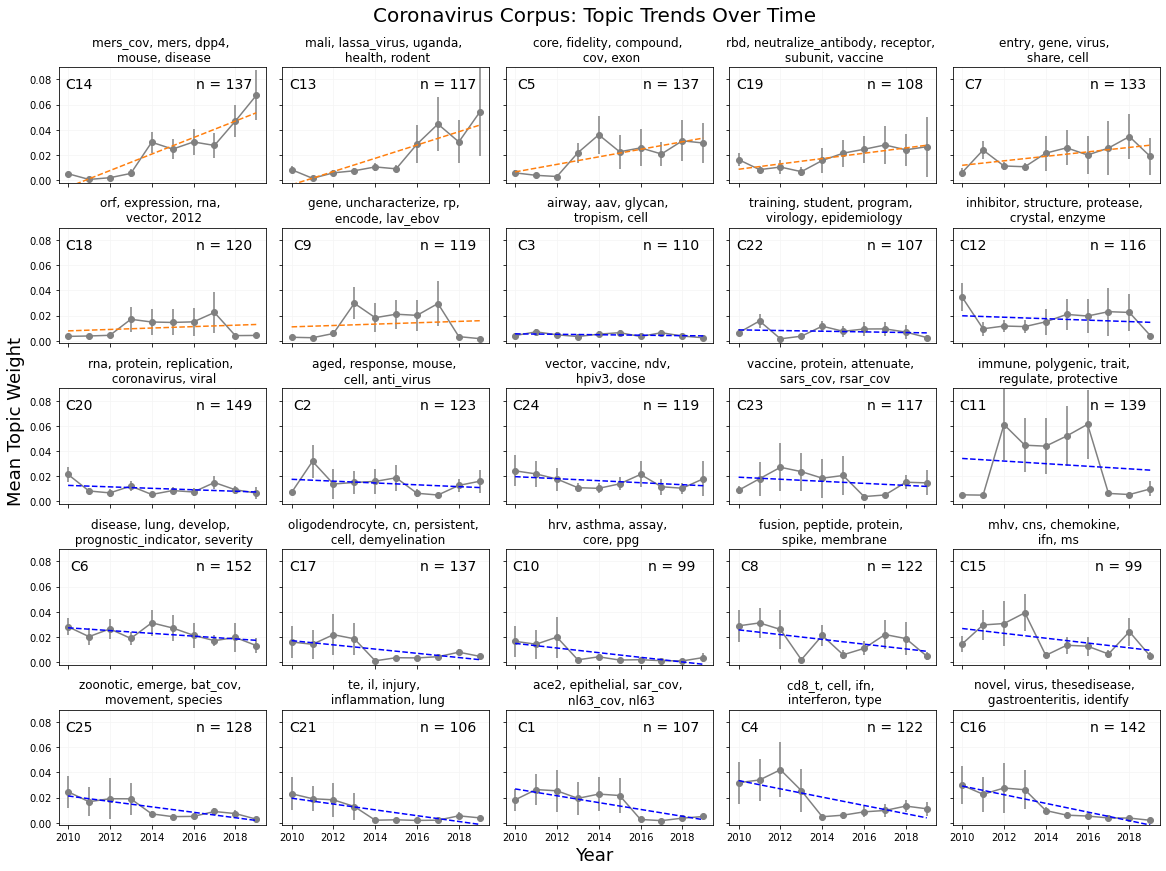

In [52]:
# set up grid
fig, ax = plt.subplots(5, 5, sharex = True, sharey = True, figsize=(16,12))
plt.ylim(bottom = -0.002, top = 0.09)  

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes):
    
    col = topic_wts_2010_2019.columns[col_idx+1]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = stats.linregress(topic_wts_2010_2019["START_YEAR"].values, topic_wts_2010_2019[col].values)
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.slope > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[i,j].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], 
            yerr = np.array(topic_wts_se_2010_2019[col]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.slope)+linear_fit.intercept, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")
    
    # add annotations - number of nonzero project topic weights per point
    #for k, txt in enumerate(topic_counts_filt[col]):
    #    ax[i,j].annotate(txt, xy = (topic_wts_2010_2019["START_YEAR"][k+25], topic_wts_2010_2019[col][k+25]), \
    #                    xycoords = 'data', xytext = (1,8), textcoords = "offset points")

    # put legend on two lines for topics 17, 21
    #if count == 16:
    #    ax[i,j].set_title('interagency_agreement_niaid, \n avian_influenza, basic, swine, pathogenic', \
    #                      fontsize = 12)
    #elif count == 27:
    #    ax[i,j].set_title('poultry, transmission, \n avian_influenza_virus, raptor, bird', fontsize = 12)
    #else:
    ax[i,j].set_title(new_leg[col_idx], fontsize = 12)
    
    # add topic number to each plot
    ax[i,j].text(0.10, 0.85, str(L_df['Label'].iloc[col_idx]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    ax[i,j].text(0.80, 0.85, "n = " + str(n_by_topic[col_idx]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    
fig.suptitle('Coronavirus Corpus: Topic Trends Over Time', fontsize = 20)
fig.text(0.5, -0.002, 'Year', ha='center', va='center', fontsize = 18)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 18)
fig.tight_layout()
fig.subplots_adjust(top=0.91)

#plt.savefig("TM_cor_topic_trends.png", dpi = 800, bbox_inches = "tight")
plt.show()

### Descriptive statistics on corpus

In [53]:
df["START_YEAR"].value_counts()

2008    56
2009    50
2011    45
2010    42
2013    41
2014    39
2015    39
2016    36
2012    32
2018    32
2017    25
2005    16
2019    15
2007    14
2004    13
2006     9
1991     6
2001     6
1985     5
2002     4
1998     3
1975     2
1999     2
1980     2
1988     2
2003     1
1990     1
1979     1
2000     1
1977     1
Name: START_YEAR, dtype: int64

In [54]:
df["DEPARTMENT"].value_counts()

HHS     516
USDA     16
NSF       6
DOD       2
VA        1
Name: DEPARTMENT, dtype: int64

In [55]:
# filter data frame by year and repeat descriptive statistics.  Limit years to those for emerging topic analysis.

filt_df = df.copy()
filt_df["START_YEAR"] = filt_df["START_YEAR"].astype('int')

filt_df = filt_df[filt_df["START_YEAR"] > 2009]
filt_df = filt_df[filt_df["START_YEAR"] < 2020]

In [56]:
year_counts = filt_df["START_YEAR"].value_counts().sort_index()
print(year_counts)

2010    42
2011    45
2012    32
2013    41
2014    39
2015    39
2016    36
2017    25
2018    32
2019    15
Name: START_YEAR, dtype: int64


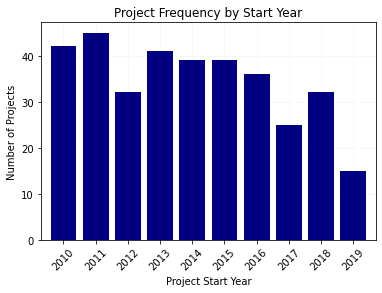

In [57]:
# plot
year = year_counts.index.tolist()
count = year_counts.values

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(True, color = "whitesmoke")
plt.bar(year, count, color='navy')
plt.xticks(year, rotation=45)
plt.xlim(2009.3,2019.7)
#x_ticks = ax.xaxis.get_major_ticks()
#x_ticks[-1].label1.set_visible(False)
plt.xlabel("Project Start Year")
plt.ylabel("Number of Projects")
plt.title("Project Frequency by Start Year");

#plt.savefig("cor_startyr_freq.png", dpi = 800, bbox_inches = "tight")

In [58]:
agency_counts = filt_df["DEPARTMENT"].value_counts()
print(agency_counts)

HHS     327
USDA     11
NSF       6
DOD       2
Name: DEPARTMENT, dtype: int64


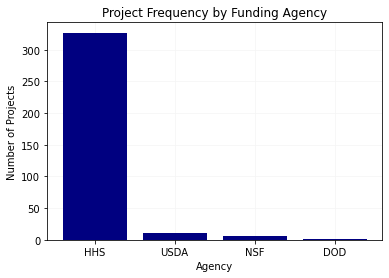

In [59]:
# plot
agency = agency_counts.index.tolist()
count = agency_counts.values

#reload(plt)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(True, color = "whitesmoke")
plt.bar(agency, count, color='navy')
plt.xlabel("Agency")
plt.ylabel("Number of Projects")
plt.title("Project Frequency by Funding Agency");

#plt.savefig("cor_agency_dist.png", dpi = 800, bbox_inches = "tight")

In [60]:
filt_df.pivot_table(index=['DEPARTMENT','START_YEAR'], aggfunc='size')

DEPARTMENT  START_YEAR
DOD         2018           2
HHS         2010          41
            2011          42
            2012          32
            2013          40
            2014          37
            2015          35
            2016          32
            2017          24
            2018          29
            2019          15
NSF         2015           2
            2016           2
            2017           1
            2018           1
USDA        2010           1
            2011           3
            2013           1
            2014           2
            2015           2
            2016           2
dtype: int64

In [61]:
filt_df.shape

(346, 33)

## Scratch work 

**try other ways to show topic prevalence, number of projects, project costs**

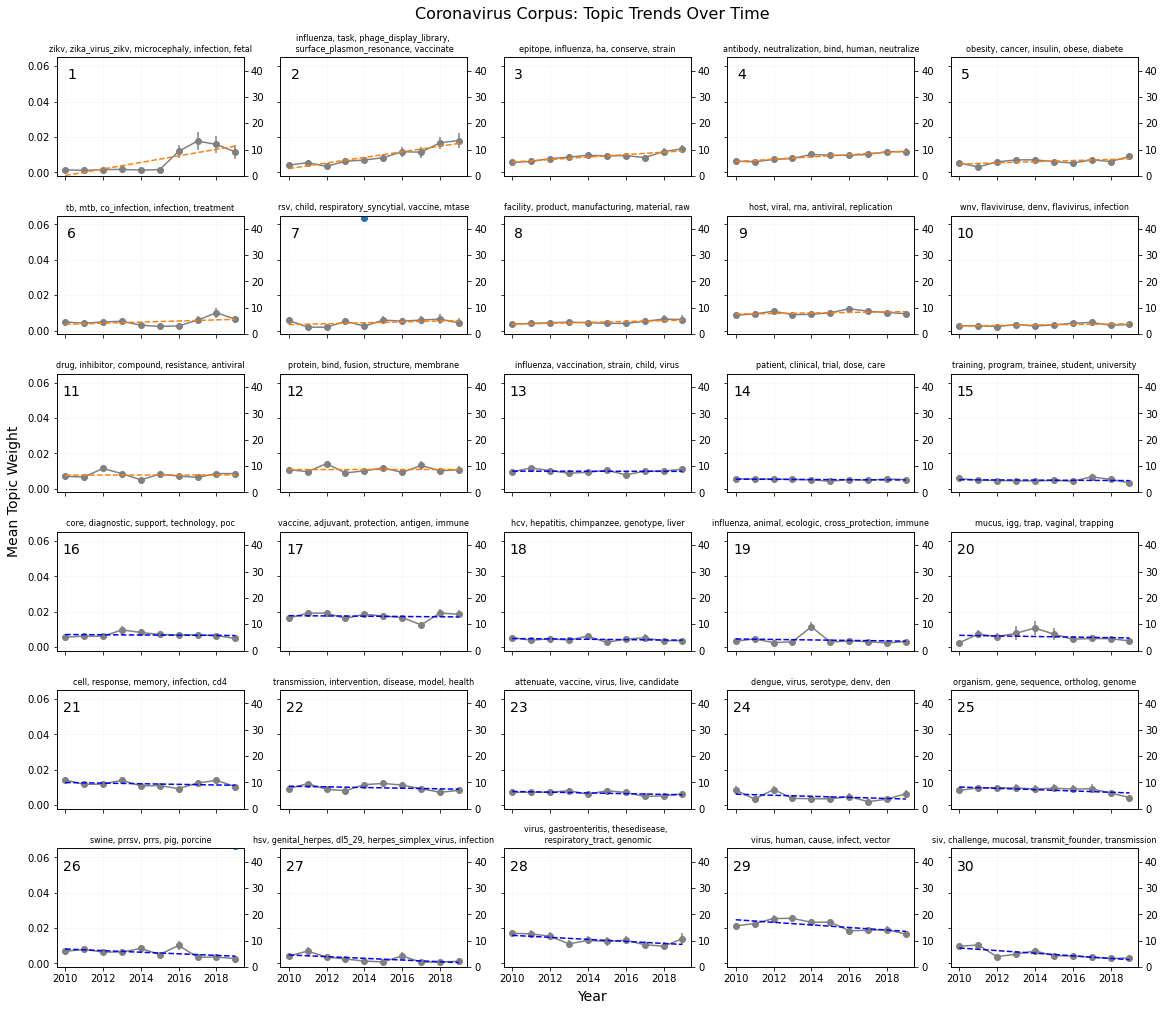

In [61]:
# dual axis approach

# set up grid
fig, ax = plt.subplots(6, 5, sharex = True, sharey = True, figsize=(16,14))
plt.ylim(bottom = -0.002, top = 0.065)

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes):
    
    col = topic_wts_2010_2019.columns[col_idx]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = lm().fit(
        topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019[col].values.reshape(-1,1))
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.coef_[0][0] > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[i,j].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], 
            yerr = np.array(topic_wts_se_2010_2019[col]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")
    
    # try dual axis
    ax2 = ax[i,j].twinx()
    ax2.plot(topic_wts_2010_2019["START_YEAR"], topic_counts_filt[col], '-o')
    ax2.set_ylim(0,45)
    

    # put legend on two lines for topics 2, 28
    if count == 1:
        ax[i,j].set_title('influenza, task, phage_display_library, \n surface_plasmon_resonance, vaccinate', \
                          fontsize = 8)
    elif count == 27:
        ax[i,j].set_title('virus, gastroenteritis, thesedisease, \n respiratory_tract, genomic', fontsize = 8)
    else:
        ax[i,j].set_title(leg[col_idx-1], fontsize = 8)
    
    # add topic number to each plot
    ax[i,j].text(0.08, 0.85, str(count+1), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    
fig.suptitle('Coronavirus Corpus: Topic Trends Over Time', fontsize = 16)
fig.text(0.5, -0.002, 'Year', ha='center', va='center', fontsize = 14)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 14)
fig.tight_layout()
fig.subplots_adjust(top=0.93)

#plt.savefig("../figures/coronavirus/topic_trends.png", dpi = 800, bbox_inches = "tight")
plt.show()

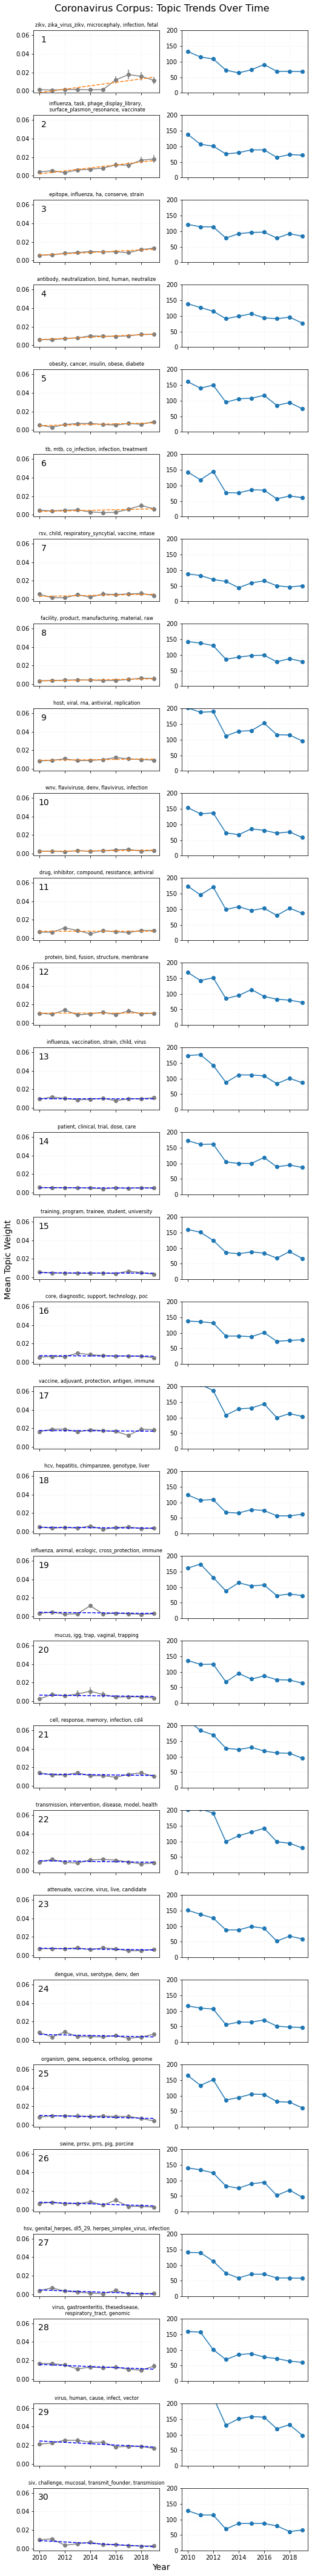

In [64]:
# try with multiple graphs per topic

# set up grid
fig, ax = plt.subplots(30, 2, sharex = True, sharey = 'col', figsize=(7,60))
#plt.ylim(bottom = -0.002, top = 0.065)

# create plots for each row
for count,col_idx in enumerate(sorted_slopes):
    
    col = topic_wts_2010_2019.columns[col_idx]
    
    # 1: mean topic weights plot
    
    linear_fit = lm().fit(
        topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019[col].values.reshape(-1,1))
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.coef_[0][0] > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[count,0].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], 
            yerr = np.array(topic_wts_se_2010_2019[col]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[count,0].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[count,0].grid(color = "whitesmoke")
    
    # put title on two lines for topics 2, 28
    if count == 1:
        ax[count,0].set_title('influenza, task, phage_display_library, \n surface_plasmon_resonance, vaccinate', \
                          fontsize = 8)
    elif count == 27:
        ax[count,0].set_title('virus, gastroenteritis, thesedisease, \n respiratory_tract, genomic', fontsize = 8)
    else:
        ax[count,0].set_title(leg[col_idx-1], fontsize = 8)
    
    # add topic number to each plot
    ax[count,0].text(0.08, 0.85, str(count+1), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[count,0].transAxes, fontsize = 14)
    
    ax[count,0].set_ylim(-0.002,0.065)
    
    # 2. Number of projects plot

    ax[count,1].plot(topic_wts_2010_2019["START_YEAR"], topic_counts_filt[col], '-o')
    ax[count,1].set_ylim(0,200)
    ax[count,1].grid(color = "whitesmoke")
    
    
fig.suptitle('Coronavirus Corpus: Topic Trends Over Time', fontsize = 16)
fig.text(0.5, 0, 'Year', ha='center', va='center', fontsize = 14)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 14)
fig.tight_layout()
fig.subplots_adjust(top=0.97)

#plt.savefig("../figures/coronavirus/topic_trends.png", dpi = 800, bbox_inches = "tight")
plt.show()